# Telco Churn Classification Project

This project is designed to identify key drivers of customer churn and develop a model to best predict future customer churn. The results from this project arms telco business leaders and decision makers with a focused direction to best address these drivers and retain customers. 

In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import acquire
import prepare
import explore
import model

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for statistical analysis
import scipy.stats as stats

# for model evaluation
import sklearn.metrics as met
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#filter out noise
import warnings
warnings.filterwarnings('ignore')

## Executive Summary:

- The classification models created (Logistic Regression, Random Forest, and KNeighbors) produced varying levels of accuracy and recall.
- The Logistic Regression model produced the best results at 79% recall. Maximizing recall will predict the most churning customers and minimize false negatives. This model is built to delve into the root of the problem, not to isolate predicted churning customers for targeted marketing. Follow on models before marketing campaigns are highly recommended. 
- With more time, I predict feature engineering data to identify a subgroup of fiber optic users with high-monthly charges and low tenure would increase the model's recall rate.
- I recommend conducting research in possible competitors offering fiber optic. My best model evaluated the fiber optic feature to have a weight of 2.78 (the closer to 1, the less impact on churn), over twice the next highest weight in the model's decision function. This heavily suggests customers are leaving due to this service and it is likely it is being offered faster or for less.

## 1. Planning

 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
     - predictions.csv including customer id, probability of churn, and prediction of churn
 - Bring over functional acquire.py, prepare.py, explore.py, and model.py files
 - Acquire the data from the Code Up database via the acquire.py function
 - Prepare and split the data via the prepare.py functions
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Model a baseline in predicting churn and document the accuracy.
 - Fit and train three (3) classification models to predict churn on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Develop and document all findings, takeaways, recommendations and next steps. 

## 2. Data Acquisition

In this step, I called my get_telco_data function. This function:
- grabs the data from the CodeUp database via a SQL query
- creates a local CSV of the table, if not already saved locally

#### Data Dictionary
----

| Target | Type | Description |
| ---- | ---- | ---- |
| churn | int | 0 if the customer is still with the company, 1 if they have left/churned |

-----

| Feature Name | Type | Description |
| ---- | ---- | ---- |
| Bank transfer (automatic) | int | 0 if the customer does not use bank transfering, 1 if they do |
| contract_type | int | 12 for month-to-month contract, 1 for 1 year contract, 2 for 2 year contract |
| contract_type_id | int | foreign key to contract_type |
| Credit card (automatic) | int | 0 if the customer does not use a credit card, 1 if they do |
| customer_id | object | individual customer identifier |
| dependents | int | 0 if the customer does not have dependents, 1 if they do |
| device_protection | int | 0 if the customer does not have device protection, 1 if they do |
| DSL | int | 0 if the customer does not have DSL, 1 if they do |
| Electronic check | int | 0 if the customer does not use electronic checks, 1 if they do |
| extras | int | count of add-on services the customer is subscribed to (online security, online backup, device protection, tech support, streaming tv, streaming movies) | 
| Fiber optic | int | 0 if the customer does not have fiber optic, 1 if they do |
| gender | int | 0 if the customer is female, 1 if they are male |
| internet_service_type_id | int | foreign key to internet_service_type |
| Mailed check | int | 0 if the customer does not use mailed checks, 1 if they do |
| monthly_charges | float | price of monthly services charged to the customer each month |
| multiple_lines | int | 0 if the customer does not have any lines, 1 if they have one line, 2 if they have two or more lines |
| online_backup | int | 0 if the customer does not have online backup, 1 if they do |
| online_security | int | 0 if the customer does not have online security, 1 if they do |
| paperless_billing | int | 0 if customer does not have paperless billing, 1 if they do |
| partner | int | 0 if the customer does not have a partner, 1 if they do |
| payment_type | object | This feature gets broken down into: bank transfer, credit card, electronic check, and mailed check |
| payment_type_id | int | foreign key to payment_type |
| phone_service | int | 0 if the customer does not have phone service, 1 if they do |
| senior_citizen | int | 0 for non-senior citizen customers, 1 for senior citizens |
| streaming_movies | int | 0 if the customer does not have streaming movies, 1 if they do |
| streaming_tv | int | 0 if the customer does not have streaming tv, 1 if they do |
| tech_support | int | 0 if the customer does not have tech support, 1 if they do |
| tenure | int  | years customer has been with telco |
| total_charges | float | sum of all charges over the tenure of the customer |

In [2]:
# Acquire the data
telco = acquire.get_telco_data()

In [3]:
# Look at it's rows and columns (observations and features)
telco.shape

(7043, 24)

### Acquisition Takeaways

- The telco data brings in 24 columns of data over 7043 observations.
- Foreign key columns are creating duplicates. These will be cleaned in the next phase.

## 3. Data Preparation

In this step, I called prep_telco from my prepare.py file. This function 
- handles nulls
- drops the foreign id columns
- casts monetary columns to floats
- enumerates columns's data for ease of exploration and modeling (See Data Dictionary above or in README for details.)

More specifically:
- internet_service_type_id, payment_type_id, and contract_type_id were dropped because they are foreign keys to other features that were merged to the table via the initial acquire query. 
- total_charges with no entry were corrected to reflect 0. This feature was then casted into a float.
- internet_service_type and payment_type were transformed via dummies. This change displays the categorical options for each feature in their own boolean-like columns with 1 for True and 0 for False.
- contract_type, gender, partner, dependents, phone_service, paperless_billing, churn, multiple_lines, online_security, online_backup, device_protection, tech_support, streaming_tv, and streaming_movies features were transformed to display 1 for True and 0 for False in place of 'Yes' or 'No'.

In [4]:
# Prepare the data
telco = prepare.prep_telco(telco)

In [5]:
# Feature engineer 'extras', a count of the add-on services available. 
telco['extras'] = telco['online_security'] + telco['online_backup']+telco['device_protection']+telco['tech_support']+ telco['streaming_tv']+telco['streaming_movies']
telco = telco.drop(columns=['online_security', 'online_backup', 'device_protection','tech_support','streaming_tv','streaming_movies'])

In [6]:
# Split the data into the datasets. 60% for train, 20% for validate, and 20% for test.
train, val, test = prepare.split_data(telco, 'churn')

In [7]:
# Check the shapes to ensure the split executed as expected
train.shape, val.shape, test.shape

((4225, 20), (1409, 20), (1409, 20))

### Preparation Takeaways

- I feature engineered a column named 'extras'. This column contains a count of all add-on subscriptions customers may add. The amount of extras may play a role in churn. More to be explored in the next step. 
- Before moving to exploration, I split the data in train, validate, and test datasets; these were stratified for the target: churn.

## 4. Data Exploration

### Question 1: Do monthly charges have a relationship with churn?

I want to start by comparing all customers monthly charges and churned customers monthly charges.

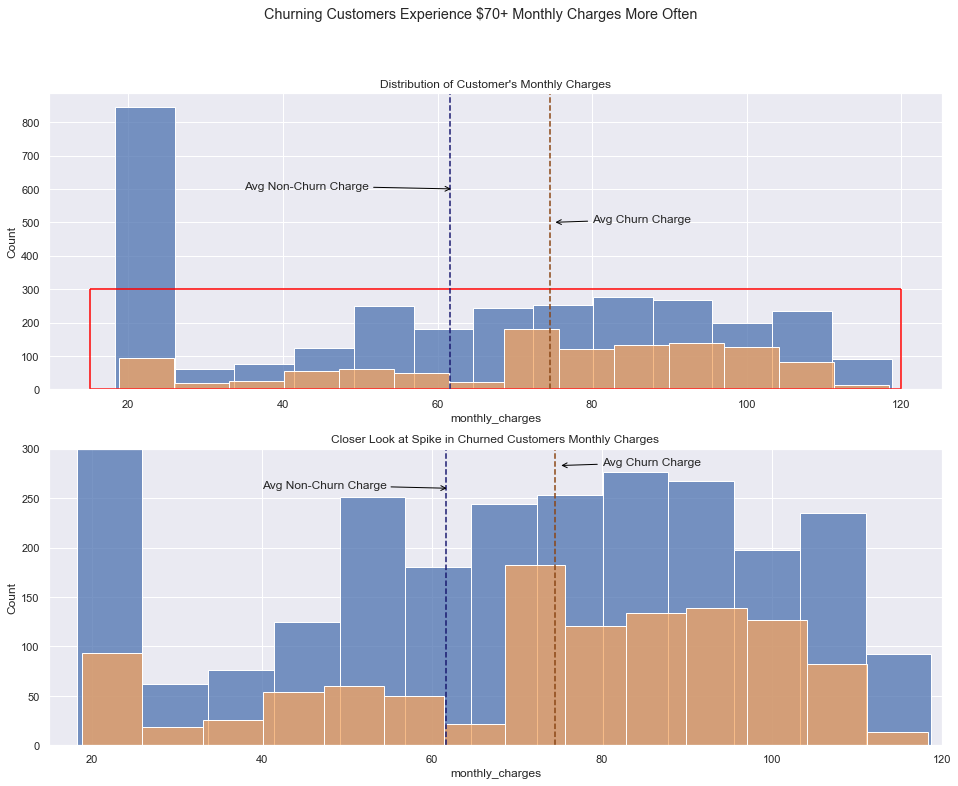

In [8]:
explore.show_monthly_charges(train)

In the above visualization, we can see the shift in the curve for customers that churned starting around $70. This suggests heavily towards there being a feature causing this spike in cost. Let's first check that this visual observation is significant using a two sample, one tail T-Test.

#### Hypothesis 1 - Monthly Charges:

    Ho -> The mean of monthly charges for churned customers is less than or equal to the mean of customers that have not churned
    Ha -> The mean of monthly charges for churned customers greater than the mean of customers that have not churned

In [9]:
# create the samples
stayed = train[train.churn == 0]
churned = train[train.churn == 1]

# set alpha
α = 0.05

# check for equal variances
stat, p = stats.levene(churned.monthly_charges, stayed.monthly_charges)

# evaluate variances based on p value
if p < α:
    print('''The two samples have differing variances.
Set equal_var to FALSE on t-test.''')
else:
    print('''The two samples have similar variances.
Proceed with t-test as normal.''')
print(' ')

The two samples have differing variances.
Set equal_var to FALSE on t-test.
 


In [10]:
# run the two-sample, one-tail T-Test
t, p = stats.ttest_ind(churned.monthly_charges, stayed.monthly_charges, equal_var = False)

# evaluate results based on the t-statistic and the p-value
if ((t > 0) & (p/2 < α)):
    print('''Reject the Null Hypothesis.
Findings suggest the average monthly charge of a churned customer is higher than customers that have not. ''')
else:
    print('''Fail to reject the Null Hypothesis.
Findings suggest the average monthly charge of a churned customer is equal to or less than customers that have not.''')
print()

Reject the Null Hypothesis.
Findings suggest the average monthly charge of a churned customer is higher than customers that have not. 



#### Question 1 Takeaways:
- There is a relationship with higher monthly charges and churn.
- There is a spike in churn starting around $70 per month in charges. 

#### Question 1b: Is there another feature causing this spike in monthly charges? After some examining of various features, I came across the relationship depicting fiber optics role in both churn and monthly charges:

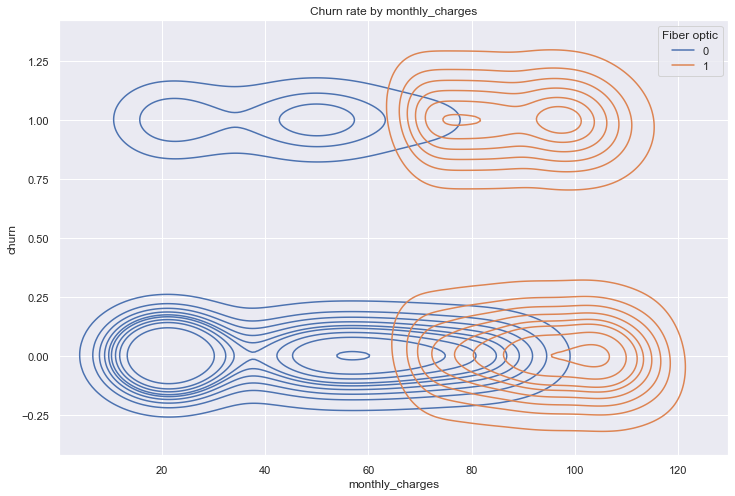

In [11]:
# Make the plot larger
plt.figure(figsize=(12,8))
# Plot it as a kdeplot, isolating fiber optic customers vs non-fiber optic customers
sns.kdeplot(data=train, x='monthly_charges', y='churn', hue='Fiber optic')
# Give it a title
plt.title('Churn rate by monthly_charges')
plt.show()

This visualization depicts a heavy density of fiber optic customers with the highest range of monthly charges in both churning and non-churning customers. This also shows that there is a higher density of churning customers with fiber optic than those without. This leads us to the next question.

-----

### Question 2: Does fiber optic drive churn?

Let's start by looking at how many customers total have fiber optic and compare the chruning rate of each group. 

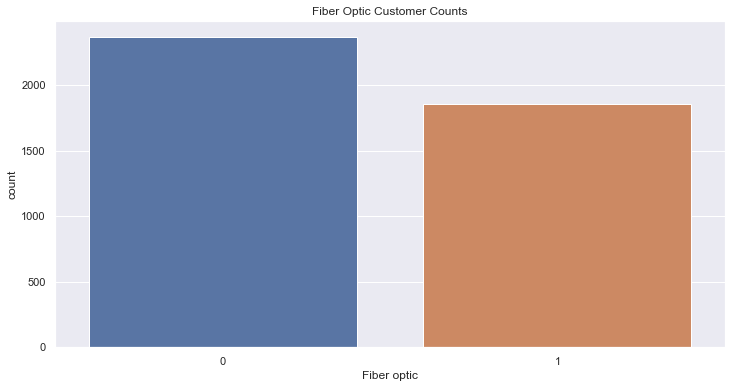

2370 customers or 56.1% do not have fiber optic.
1855 customers or 43.9% have fiber optic.

---------------------------------------------------------------------------------------------------------------



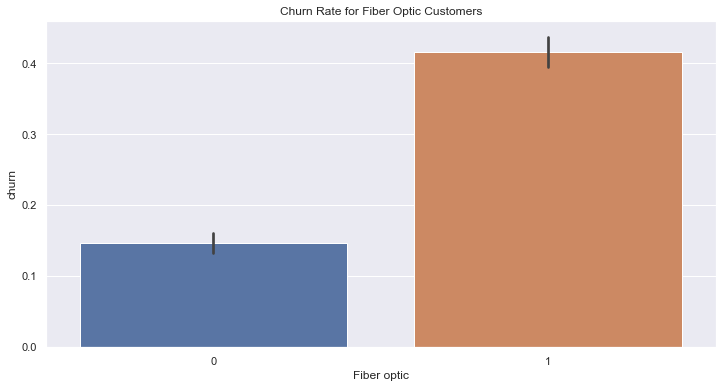

14.7% of all customers without fiber optic churn.
41.7% of all customers with fiber optic churn.


In [12]:
explore.show_fiber_optic(train)

These findings show that while less than half of customers have fiber optic (43.9%), they are churning at almost 3x the rate of customers without fiber optic (41.7% vs 14.7%). 

Next we test if this visuzalizations suggestions are actually depecting an association between fiber optic and a customer churning. 

#### Hypothesis 2 - Fiber Optic:

    Ho -> There is no association between a customer having fiber optic and a customer churning
    Ha -> There is an association between a customer having fiber optic and a customer churning

##### Chi Square Test: Fiber Optic vs Churn

In [13]:
# create observed dataset
observed = pd.crosstab(train['Fiber optic'], train.churn)

# set alpha to 0.05 (due to 95% confidence level)
α = 0.05

observed

churn,0,1
Fiber optic,,
0,2022,348
1,1082,773


In [14]:
# run chi square test
chi2, p, dof, expected = stats.chi2_contingency(observed)

# evaluate results with the p-value
if p < α:
    print('''Reject the null hypothesis.
    Findings suggest there is an association between a customer having fiber optic and a customer churning.''')
else:
    print('''Fail to reject the null hypothesis.
    Findings suggest there is no association between a customer having fiber optic and a customer churning.''')
print()

Reject the null hypothesis.
    Findings suggest there is an association between a customer having fiber optic and a customer churning.



#### Question 2 Findings:
- Findings suggest there is an association between a customer having fiber optic and a customer churning.
- 41.7% of customers with fiber optic have churned
- Customers with fiber optic churn over twice as much as customers without fiber optic.

### Question 3: What is tenure's role in churn?

Let's start by looking at the distribution of all customers tenures and then just churned customers

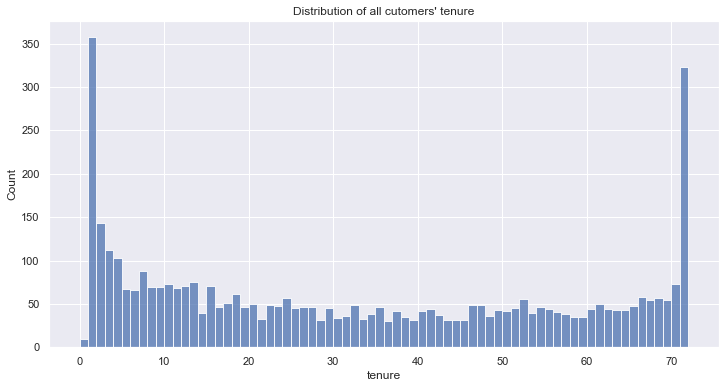

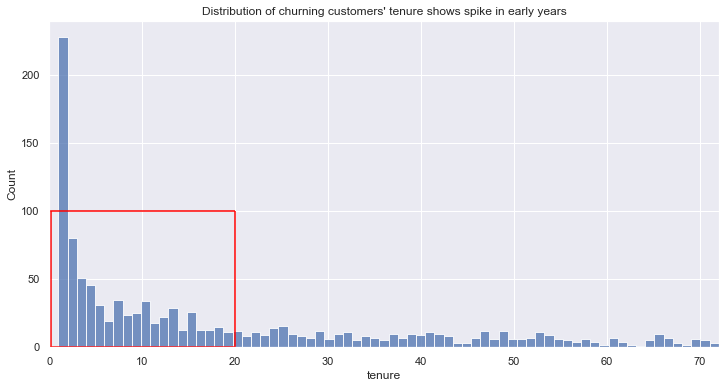

These two histographs show that customers churn the most early on in tenure. This makes sense with new customer deals expiring. There seems to be another drop off. Let's zoom in and look at the first 20 years of churning customers



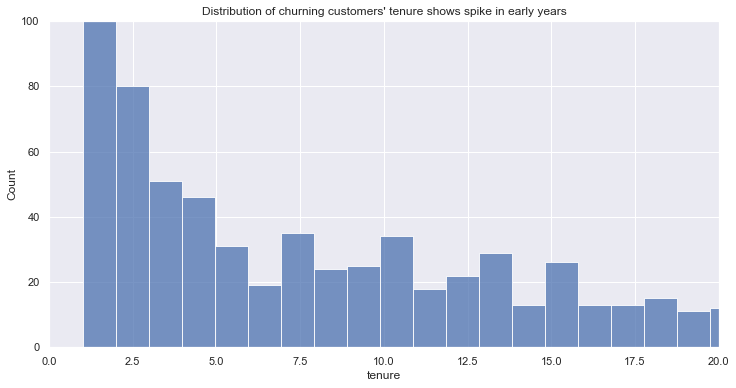

In [15]:
explore.show_tenure(train)

Customers seem to be churning at higher rates up until year 15 where it begins to level off. 

#### Hypothesis 3 - Tenure:

    Ho -> There is not an association between tenure and churn
    Ha -> There is an association between tenure and churn

In [16]:
# create observed data
observed = pd.crosstab(train.tenure, train.churn)

# set alpha with 95% confidence
α = 0.05

# run the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(observed)

# evaluate results with the p-value
if p < α:
    print('''Reject the null hypothesis.
    Findings suggest there is an association between tenure and churning.''')
else:
    print('''Fail to reject the null hypothesis.
    Findings suggest there is no association between tenure and churning.''')
print()

Reject the null hypothesis.
    Findings suggest there is an association between tenure and churning.



Does this association persist if the first 15 years are removed from the observed data?

In [17]:
# create observed data
observed = pd.crosstab(train[train.tenure > 15].tenure, train[train.tenure > 15].churn)

# set alpha with 95% confidence
α = 0.05

# run the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(observed)

# evaluate results with the p-value
if p < α:
    print('''Reject the null hypothesis.
    Findings suggest there is an association between tenure and churning.''')
else:
    print('''Fail to reject the null hypothesis.
    Findings suggest there is no association between tenure and churning.''')
print()

Reject the null hypothesis.
    Findings suggest there is an association between tenure and churning.



#### Question 3 Findings:
- Findings suggest there is an association between tenure and churning.
- The most churn happens between year 0 and year 15.
- However even without customers with less than 15 years in tenure, the association between tenure and churn remains.

### Bring all three drivers together

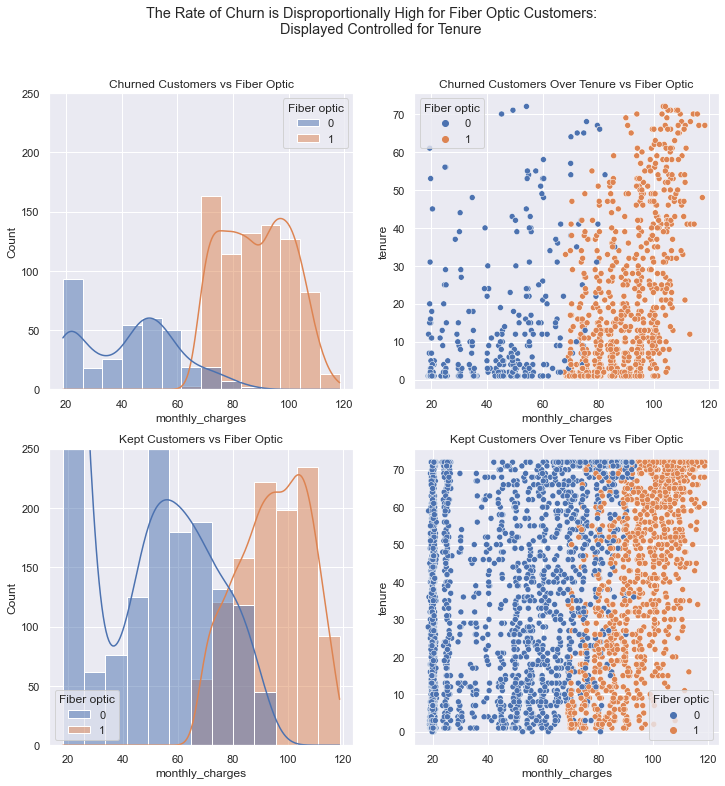

In [18]:
explore.show_combo(train)

### Explore Takeaways:
- Increased monthly charges, having fiber optic, and early in tenure all lead to higher rates of churn. 
- A disporportionatly high number of customers that churn have fiber optic when compared to customers that do not churn. 
- When controling for tenure, this theme continues. More fiber optic customers churn than non-fiber optic customers. 

## 5. Data Modeling

Many features will be dropped in order to maximize model fitting based on our findings. (See working_report.ipynb for chi square results.)
- Features not moving forward to modeling due to low observed impact on churn during data exploration:
    - customer_id
    - partner
    - dependents
    - phone_service
    - multiple_lines
    - Bank transfer
    - Credit card
    - Electronic check
    - Mailed check
    - total_charges
    - gender
- Features that will be used in modeling:
    - contract_type -> month to month contracts allow customers to churn at any time opposed to being locked in for a year or two
    - Fiber optic -> findings from question 2 suggest a significant relationship with churn
    - DSL -> the alternative choice from fiber optic. The current findings suggest a significant relationship with fiber optic and churn
    - monthly_charges -> findings from question one suggest there is a significant relationship with churn
    - paperless_billing -> findings during exploration show there might be a significant relationship with churn (see working_report.ipynb for more)
    - senior_citizen -> findings during exploration show there might be a significant relationship (see working_report.ipynb for more)
    - tenure -> findings from question three suggest there is a significant relationship with churn
    - extras -> findings during exploration show there is a relationship with more extras lowering churn

#### My goal is to maximize recall while maintaining a consistent results in order to prevent overfitting the models.
- My models and their hyperparameters to avoid overfitting are as follows:
    - Logistic Regression: C = 1.0, frequency = 0.3, random_state = 123
    - Random Forest: max_depth = 7, min_samples_leaf = 3, random_state = 123
    - K-Nearest Neighbors: n_neighbors = 5, weights = 'uniform'


In [30]:
# set up our train, validate, and test values
X_train, y_train, X_val, y_val, X_test, y_test = model.setup(train, val, test)

### Baseline Accuracy
Because most customers do not churn (0), the baseline will be predicting all customers do not churn.

In [31]:
# Find baseline accuracy
baseline_accuracy = (y_train == 0).mean()
print(f'My baseline accuracy is: {round(baseline_accuracy*100, 2)}%.')
print()

My baseline accuracy is: 73.47%.



- Using the baseline to find recall will always return 100% recall because the baseline model cannot produce cases where it predits churn when a customer does not (false negative cases). 
- Due to wanting to capture as many churning customers as possible, my models will look at optimizing recall. 

#### Model 1: Logistic Regression

In [21]:
logit_results = model.make_logit(X_train, y_train, X_val, y_val)

#### Model 2: Random Forest

In [22]:
forest_results = model.make_forest(X_train, y_train, X_val, y_val)

#### Model 3: K-Nearest Neighbor

In [23]:
knn_results = model.make_knn(X_train, y_train, X_val, y_val)

#### Model Results:

In [24]:
# Put all the results into one dataframe
pd.concat([logit_results, forest_results, knn_results], axis=1).T

,accuracy_train,accuracy_validate,recall_train,recall_validate
logit_results,0.752426,0.765791,0.742194,0.783422
forest_results,0.817278,0.808375,0.533452,0.516043
knn_results,0.840237,0.776437,0.624442,0.524064


### Modeling Takeaways:
- My Logistic Regression model is performing at a lower accuracy but higher recall at 74% on train to 78% on validate. This is the best model to maximize recall.
- My Random Forest model performed with the best accuracy but much lower recall than the Logistic Regression model. This is the best model to maximize accuracy.
- My K-Nearest Neighbors model produced inconsistent results in both accuracy and recall. This is not a good model to move forward with.
- All of these models predict churn better than my baseline accuracy at 73%
- Going forward I would look into other classifier algorithms to create different models. 
- Because I want to maximize recall, I am going to move forward with my Logistic Regression model. 

## 6. Model Evaluation

#### Evaluate the best model with the test dataset

In [25]:
best, odds, predictions = model.run_best_test(X_train, y_train, X_val, y_val, X_test, y_test, test)

In [27]:
# Lets see the test results compared to the train and validate!
best

,Accuracy,Recall
train,0.752426,0.742194
validate,0.765791,0.783422
test,0.759404,0.778075


In [28]:
# Look at each features coefficients for this model
odds

,weight_of_feature
senior_citizen,1.405546
tenure,0.966208
paperless_billing,1.587322
monthly_charges,1.015323
contract_type,1.102415
DSL,1.633308
Fiber optic,2.781502
extras,0.922522


#### Create Predictions

- Create a csv file with customer id, probability of staying, probability of churning, and prediction of churn.
- These predictions were built with my logistic regression model.

In [29]:
# Lets see the predictions from the best model! (Also saved in a local CSV)
predictions

,customer,probability_of_staying,probability_of_churn,prediction
0,4531-AUZNK,0.864178,0.135822,Stay
1,2296-DKZFP,0.975314,0.024686,Stay
2,9692-TUSXH,0.408492,0.591508,Churn
3,5129-JLPIS,0.472033,0.527967,Churn
4,1273-MTETI,0.238113,0.761887,Churn
...,...,...,...,...
1404,1597-FZREH,0.61151,0.38849,Churn
1405,9117-SHLZX,0.525355,0.474645,Churn
1406,8441-SHIPE,0.984352,0.015648,Stay
1407,3511-BFTJW,0.987013,0.012987,Stay


# CONCLUSTION

Fiber optic customers consistently churn at a higher rate throughout all tenure lengths. My best model evaluated at a 77.8% recall rate during the test and identified the fiber optic feature to have a weight of 2.78 (the closer to 1, the less impact on churn), almost twice the next highest weight in the model's decision function. It is this feature that should be addressed. 

### Recommendations: 
 - Conduct research on other fiber optic providers. There is likely a competitor providing this service to customers faster, better, or cheaper.
 - Add data or begin tracking customers' location of service. Customers may be able to sign up even if fiber optic is not available in their area. Service outages causing churn may be geographically clustered. 
 - Evaluate fiber optic customers' experience early and often. Themes in this customer feeback could point the company in a direction to better deter churn. 

### Next Steps:
 - Feature engineer sample populations where the cluster of churn is at for a combination of features. Example: isolate customers with low-tenure and high monthly charges, add an identifier for this group, and see how this additional identifier adjusted the model outcomes. 
 - Feature engineer data to show the last added on service before churn and the difference in dates between the addition and churning. This information could shed light on a specific service lowering customer satisfaction.

- The classification models created (Logistic Regression, Random Forest, and KNeighbors) produced varying levels of accuracy and recall.
- The Logistic Regression model produced the best results at 79% recall. Maximizing recall will predict the most churning customers and minimize false negatives. This model is built to delve into the root of the problem, not to isolate predicted churning customers for targeted marketing. Follow on models before marketing campaigns are highly recommended. 
- With more time, I predict feature engineering data to identify a subgroup of fiber optic users with high-monthly charges and low tenure would increase the model's recall rate.
- I recommend conducting research in possible competitors offering fiber optic. My best model evaluated the fiber optic feature to have a weight of 2.78 (the closer to 1, the less impact on churn), over twice the next highest weight in the model's decision function. This heavily suggests customers are leaving due to this service and it is likely it is being offered faster or for less.